In [ ]:
# =========================
# 1. Setup Colab environment
# =========================
!pip install kaggle --quiet

# Upload the kaggle.json file (Get it from your Kaggle account > My Account > Create New API Token)
from google.colab import files
files.upload()  # Select kaggle.json

# Setup Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



Saving kaggle.json to kaggle.json


In [ ]:
# =========================
# 2. Download Retina Blood Vessel dataset from Kaggle
# =========================
!kaggle datasets download -d abdallahwagih/retina-blood-vessel

# Unzip the dataset
!unzip -q retina-blood-vessel.zip -d /content/retina

# List files to verify
!ls /content/retina/Data/train/image | head
!ls /content/retina/Data/train/mask | head


Dataset URL: https://www.kaggle.com/datasets/abdallahwagih/retina-blood-vessel
License(s): apache-2.0
  0% 0.00/32.9M [00:00<?, ?B/s]
100% 32.9M/32.9M [00:00<00:00, 446MB/s]
0.png
10.png
11.png
12.png
13.png
14.png
15.png
16.png
17.png
18.png
0.png
10.png
11.png
12.png
13.png
14.png
15.png
16.png
17.png
18.png


In [ ]:
# =========================
# 3. Import libraries
# =========================
import os
import cv2
import time
import random
import numpy as np
from glob import glob
from tqdm import tqdm
from operator import add

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score


In [ ]:
# =========================
# 4. Define Dataset
# =========================
class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path, size=(512, 512)):
        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)
        self.size = size

    def __getitem__(self, index):
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)

        # Resize
        image = cv2.resize(image, self.size)
        mask = cv2.resize(mask, self.size)

        # Normalization
        image = image / 255.0
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        image = torch.from_numpy(image)

        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=0).astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples


In [ ]:
# =========================
# 5. Build UNet model as in the original code
# =========================
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs); x = self.bn1(x); x = self.relu(x)
        x = self.conv2(x); x = self.bn2(x); x = self.relu(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)
        self.conv = conv_block(out_c+out_c, out_c)
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        self.b = conv_block(512, 1024)
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
        self.outputs = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, inputs):
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        b = self.b(p4)
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        outputs = self.outputs(d4)
        return outputs

class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()
    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        return BCE + dice_loss


In [ ]:
# =========================
# 6. Prepare data and DataLoader
# =========================
train_x = sorted(glob("/content/retina/Data/train/image/*"))
train_y = sorted(glob("/content/retina/Data/train/mask/*"))
valid_x = sorted(glob("/content/retina/Data/test/image/*"))
valid_y = sorted(glob("/content/retina/Data/test/mask/*"))

print("Train size:", len(train_x))
print("Valid size:", len(valid_x))

train_dataset = DriveDataset(train_x, train_y)
valid_dataset = DriveDataset(valid_x, valid_y)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=2)


Train size: 80
Valid size: 20


In [ ]:
# =========================
# 7. Train the model
# =========================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = build_unet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = DiceBCELoss()

def train_epoch(model, loader):
    model.train()
    epoch_loss = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss/len(loader)

def eval_epoch(model, loader):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()
    return epoch_loss/len(loader)

best_loss = float("inf")
for epoch in range(30):  # You can increase the number of epochs
    train_loss = train_epoch(model, train_loader)
    val_loss = eval_epoch(model, valid_loader)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "/content/unet_best.pth")

    print(f"Epoch [{epoch+1}/30] Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")


Epoch [1/30] Train Loss: 1.1265  Val Loss: 1.2300
Epoch [2/30] Train Loss: 0.9214  Val Loss: 0.8852
Epoch [3/30] Train Loss: 0.8637  Val Loss: 0.8482
Epoch [4/30] Train Loss: 0.8152  Val Loss: 0.7943
Epoch [5/30] Train Loss: 0.7739  Val Loss: 0.7532
Epoch [6/30] Train Loss: 0.7382  Val Loss: 0.7211
Epoch [7/30] Train Loss: 0.7094  Val Loss: 0.6915
Epoch [8/30] Train Loss: 0.6777  Val Loss: 0.6664
Epoch [9/30] Train Loss: 0.6512  Val Loss: 0.6564
Epoch [10/30] Train Loss: 0.6276  Val Loss: 0.6314
Epoch [11/30] Train Loss: 0.6034  Val Loss: 0.5893
Epoch [12/30] Train Loss: 0.5789  Val Loss: 0.5855
Epoch [13/30] Train Loss: 0.5578  Val Loss: 0.5574
Epoch [14/30] Train Loss: 0.5380  Val Loss: 0.5365
Epoch [15/30] Train Loss: 0.5182  Val Loss: 0.5255
Epoch [16/30] Train Loss: 0.5026  Val Loss: 0.5120
Epoch [17/30] Train Loss: 0.4838  Val Loss: 0.4885
Epoch [18/30] Train Loss: 0.4673  Val Loss: 0.4790
Epoch [19/30] Train Loss: 0.4531  Val Loss: 0.4713
Epoch [20/30] Train Loss: 0.4391  Val Lo

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score

def calculate_metrics_vessel(y_true, y_pred):
    """
    Calculate: Accuracy, Sensitivity, Specificity, AUC, F1
    """
    y_true = y_true.cpu().numpy().astype(np.uint8)
    y_pred = (y_pred.cpu().numpy() > 0.5).astype(np.uint8)

    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()

    acc = (tp + tn) / (tp + tn + fp + fn + 1e-8)
    se  = tp / (tp + fn + 1e-8)  # Sensitivity (Recall)
    sp  = tn / (tn + fp + 1e-8)  # Specificity
    f1  = 2*tp / (2*tp + fp + fn + 1e-8)
    auc = roc_auc_score(y_true, y_pred)

    return acc, se, sp, auc, f1


In [ ]:
import cv2, os
import numpy as np

model.load_state_dict(torch.load("/content/unet_best.pth", map_location=device))
model.eval()
os.makedirs("results", exist_ok=True)

metrics_total = np.zeros(5)  # Acc, Se, Sp, AUC, F1

for idx, (x, y) in enumerate(valid_loader):
    x = x.to(device)
    y = y.to(device)

    with torch.no_grad():
        pred = torch.sigmoid(model(x))

    # Calculate metrics
    metrics_total += np.array(calculate_metrics_vessel(y, pred))

    # Save a visual example
    img = (x[0].cpu().numpy().transpose(1,2,0)*255).astype(np.uint8)
    gt_mask = (y[0,0].cpu().numpy()*255).astype(np.uint8)
    pred_mask = (pred[0,0].cpu().numpy()>0.5).astype(np.uint8)*255

    combined = np.concatenate([
        img,
        cv2.cvtColor(gt_mask, cv2.COLOR_GRAY2BGR),
        cv2.cvtColor(pred_mask, cv2.COLOR_GRAY2BGR)
    ], axis=1)

    cv2.imwrite(f"results/sample_{idx}.png", combined)

# Average metrics
metrics_avg = metrics_total / len(valid_loader)
print(f"Accuracy (Acc):    {metrics_avg[0]:.4f}")
print(f"Sensitivity (Se):  {metrics_avg[1]:.4f}")
print(f"Specificity (Sp):  {metrics_avg[2]:.4f}")
print(f"AUC:               {metrics_avg[3]:.4f}")
print(f"F1-Score:          {metrics_avg[4]:.4f}")
print("Result images saved in the results/ folder")


Accuracy (Acc):    0.9601
Sensitivity (Se):  0.9188
Specificity (Sp):  0.9625
AUC:               0.9406
F1-Score:          0.7097
تم حفظ صور النتائج في مجلد results/


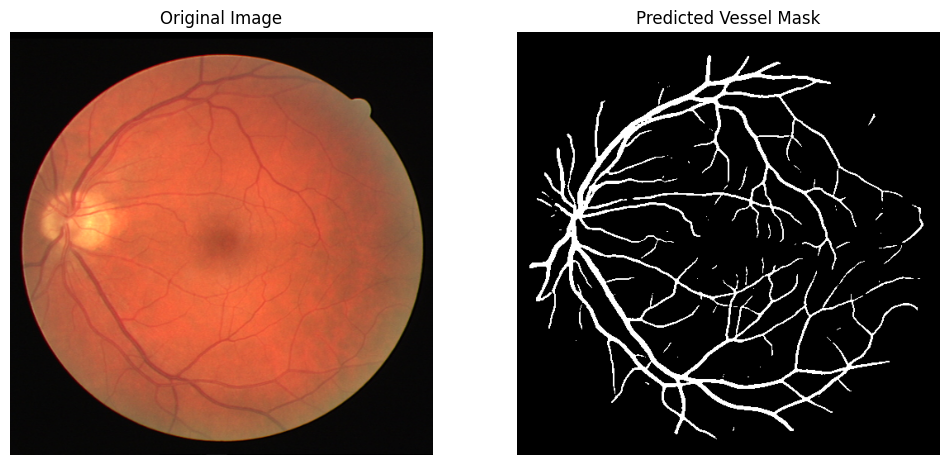

In [ ]:
import matplotlib.pyplot as plt
import cv2
import torch
import numpy as np

# Load the model
model.load_state_dict(torch.load("/content/unet_best.pth", map_location=device))
model.eval()

# Select an image from the test folder
test_image_path = "/content/retina/Data/test/image/11.png"  # Change the number as you like

# Read the image
image = cv2.imread(test_image_path, cv2.IMREAD_COLOR)
orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for display

# Resize to 512x512 like during training
image_resized = cv2.resize(image, (512, 512)) / 255.0
image_tensor = torch.tensor(image_resized.transpose(2,0,1), dtype=torch.float32).unsqueeze(0).to(device)

# Predict the mask
with torch.no_grad():
    pred = torch.sigmoid(model(image_tensor))[0,0].cpu().numpy()

# Convert to 0 and 1
mask_pred = (pred > 0.5).astype(np.uint8)*255

# Display the original image and mask
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(orig)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask_pred, cmap="gray")
plt.title("Predicted Vessel Mask")
plt.axis("off")

plt.show()
